# Machine Learning Final Project

## Part B Fast price approximator to time dependent derivatives

By Valentin PICAVET

# Monte Carlo simulations

We are asked to price time-dependant derivatives such as Asian or Barrier options. 

We decided to price Barrier options, and more particularly Up-and-In call options and Down-and-In put options as they are more frequently used by investors.

1) To do so, we first use the Geometric Brownian Motion model to generate potential future stock prices for multiple scenarios.
We determine the payoff for a given type of option based on simulated stock prices and we compute the price of the option using the mean of the payoffs, discounted to the present value using the risk-free interest rate.

In [1]:
import numpy as np
import pandas as pd

# Function to generate stock prices using Geometric Brownian Motion
def generate_stock_prices(mu, volatility, S0, n_years, n_scenarios, steps_per_year):
    np.random.seed(123)
    dt = 1 / steps_per_year
    n_steps = int(n_years * steps_per_year)
    returns = np.random.normal(loc=(1 + mu * dt), scale=(volatility * np.sqrt(dt)), size=(n_steps, n_scenarios))
    returns[0] = 1
    prices = S0 * np.cumprod(returns, axis=0)
    return prices

# Function to calculate payoff for UpInCall and DownInPut options
def calculate_payoff(stock_prices, option_type, barrier, strike):
    if option_type == 'UpInCall':
        barrier_touched = np.any(stock_prices >= barrier, axis=0)
        end_prices = stock_prices[-1]
        payoff = np.where(np.logical_and(barrier_touched, (end_prices - strike) >= 0),
                          end_prices - strike, 0)
    elif option_type == 'DownInPut':
        barrier_touched = np.any(stock_prices <= barrier, axis=0)
        end_prices = stock_prices[-1]
        payoff = np.where(np.logical_and(barrier_touched, (strike - end_prices) >= 0),
                          strike - end_prices, 0)
    return pd.DataFrame(payoff)

# Function to price the option
def price_option(payoff, interest_rate, n_years):
    option_price = float(payoff.mean() * np.exp(-interest_rate * n_years))
    return option_price

2) Then, we write a code that exhaustively computes and stores the prices of barrier options for various parameter combinations. It generates a comprehensive DataFrame containing the parameter values and their corresponding option prices. Additionally, it displays the total execution time for the Monte Carlo simulation in order to compare it with the total execution time for NN later on.

In [2]:
import time

# Initialize parameter lists
mu_list = [0.03, 0.05, 0.08]
volatility_list = [0.05, 0.08, 0.10]
interest_rate_list = [0.03, 0.05, 0.07]
S0_list = [60, 70, 75]
strike_list = [70, 75, 80]
barrier_list = [80, 90, 100]
n_years_list = [5, 7, 10]

start_time = time.time()
results = []

# Loop through parameter combinations and calculate option prices
for mu in mu_list:
    for volatility in volatility_list:
        for interest_rate in interest_rate_list:
            for S0 in S0_list:
                for strike in strike_list:
                    for barrier in barrier_list:
                        for n_years in n_years_list:
                            stock_prices = generate_stock_prices(mu, volatility, S0, n_years, 1000, 256)
                            option_payoff = calculate_payoff(stock_prices, 'UpInCall', barrier, strike)
                            option_price = price_option(option_payoff, interest_rate, n_years)
                            result = pd.DataFrame({
                                "mu": [mu],
                                "volatility": [volatility],
                                "interest rate": [interest_rate],
                                "S0": [S0],
                                "strike": [strike],
                                "barrier": [barrier],
                                "n_years": [n_years],
                                "Price": [option_price]
                            })
                            results.append(result)

df = pd.concat(results, ignore_index=True)
print(df)

end_time = time.time()
execution_time = end_time - start_time
print(f"Total time taken by Monte Carlo: {execution_time} seconds")


C:\Users\valou\AppData\Local\Temp\ipykernel_8788\3069895847.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  option_price = float(payoff.mean() * np.exp(-interest_rate * n_years))


        mu  volatility  interest rate  S0  strike  barrier  n_years      Price
0     0.03        0.05           0.03  60      70       80        5   1.600803
1     0.03        0.05           0.03  60      70       80        7   4.146984
2     0.03        0.05           0.03  60      70       80       10   8.365861
3     0.03        0.05           0.03  60      70       90        5   0.231982
4     0.03        0.05           0.03  60      70       90        7   1.410744
...    ...         ...            ...  ..     ...      ...      ...        ...
2182  0.08        0.10           0.07  75      80       90        7  31.778054
2183  0.08        0.10           0.07  75      80       90       10  43.265366
2184  0.08        0.10           0.07  75      80      100        5  21.925290
2185  0.08        0.10           0.07  75      80      100        7  31.362660
2186  0.08        0.10           0.07  75      80      100       10  43.176902

[2187 rows x 8 columns]
Total time taken by Monte C

We can see that the Monte Carlo method is quite computationally expensive and time-consuming especially because here we simulated daily prices (We assume there are 256 business days in a year).

That's why, now, we are going to design a NN to price the barrier options faster than the Monte Carlo method.

# Neural Network simulations 

We need to design a neural network suitable for the pricing of our Barrier Options.

First, we prepare the data. That is, we prepare the feature (X) and target (y) datasets for the NN. 
Then, we standardize X because it helps the NN to perform better and converge faster. 
Finally, we split the data set into training, validation and test sets. 

In [4]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam


X = df[["n_years", "mu","volatility", "interest rate", "barrier", "strike", "S0"]].values
y = df[["Price"]].values

# Standardize the feature X
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the dataset: 80% training set, 10% validation set and 10% testing set
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

We need to design the neural network architecture with the optimal number of layers, activation functions and learning rate in order to minimize the loss function. The loss function measures the disparity between predicted values and actual ground truth labels so our goal is to minimize this loss function to make accurate predictions and to ensure good generalization on new, unseen data.

To find the best parameters for our model, we use Keras tuner to perform hyperparameter tuning for our neural network-based regression model. 
The function `build_model` defines the architecture of the neural network and is used by Keras Tuner to search the hyperparameter space. We are looking for the optimal number of layers and their configurations as well as the optimal learning rate within the specified range. We use the MSE loss function because it is the appropriate one for regression. 
Finally, the tuner searches the hyperparameter space based on the provided configurations, aiming to minimize the validation loss.

I chose 40 trials to have a significant number of runs. I chose 500 epochs to give the model time to capture intricate patterns and relationships within the data.

**Warning : This code takes a long time to run. Do not run it unless if you want to find parameters that are better than the ones I found while running this code for 2 days.**

In [ ]:
pip install keras-tuner

In [177]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def build_model(hp):
    model = keras.Sequential()

    # Tune the number of layers
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                        activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'sigmoid'])))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.0001, 0.00001])),
                  loss='mean_squared_error')
    
    return model

tuner = RandomSearch(build_model, objective='val_loss', max_trials=40, executions_per_trial=3, directory='my_dir', project_name='option_pricer')

tuner.search(X_train, y_train, epochs=500, validation_data=(X_val, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val))

best_model.summary()

Trial 40 Complete [00h 11m 01s]
val_loss: 1.1059118906656902

Best val_loss So Far: 0.2824290096759796
Total elapsed time: 1d 19h 06m 04s
Epoch 1/500
55/55 [==============================] - 2s 10ms/step - loss: 425.1626 - val_loss: 275.3786
Epoch 2/500
55/55 [==============================] - 0s 8ms/step - loss: 280.6398 - val_loss: 206.4565
Epoch 3/500
55/55 [==============================] - 0s 8ms/step - loss: 235.0126 - val_loss: 188.7917
Epoch 4/500
55/55 [==============================] - 0s 6ms/step - loss: 221.6816 - val_loss: 184.5514
Epoch 5/500
55/55 [==============================] - 0s 7ms/step - loss: 216.5821 - val_loss: 182.0565
Epoch 6/500
55/55 [==============================] - 0s 6ms/step - loss: 210.4072 - val_loss: 171.5868
Epoch 7/500
55/55 [==============================] - 0s 7ms/step - loss: 184.2876 - val_loss: 128.8354
Epoch 8/500
55/55 [==============================] - 0s 6ms/step - loss: 128.7695 - val_loss: 81.5203
Epoch 9/500
55/55 [===================

55/55 [==============================] - 0s 6ms/step - loss: 0.2986 - val_loss: 0.4850
Epoch 82/500
55/55 [==============================] - 0s 7ms/step - loss: 0.3188 - val_loss: 0.5705
Epoch 83/500
55/55 [==============================] - 0s 6ms/step - loss: 0.2881 - val_loss: 0.4668
Epoch 84/500
55/55 [==============================] - 0s 6ms/step - loss: 0.2841 - val_loss: 0.5023
Epoch 85/500
55/55 [==============================] - 0s 6ms/step - loss: 0.2943 - val_loss: 0.5257
Epoch 86/500
55/55 [==============================] - 0s 6ms/step - loss: 0.3092 - val_loss: 0.5067
Epoch 87/500
55/55 [==============================] - 0s 6ms/step - loss: 0.2963 - val_loss: 0.4735
Epoch 88/500
55/55 [==============================] - 0s 6ms/step - loss: 0.2767 - val_loss: 0.4851
Epoch 89/500
55/55 [==============================] - 0s 6ms/step - loss: 0.2634 - val_loss: 0.5342
Epoch 90/500
55/55 [==============================] - 0s 6ms/step - loss: 0.2625 - val_loss: 0.4934
Epoch 91/500


55/55 [==============================] - 0s 6ms/step - loss: 0.1285 - val_loss: 0.4170
Epoch 244/500
55/55 [==============================] - 0s 6ms/step - loss: 0.1332 - val_loss: 0.4277
Epoch 245/500
55/55 [==============================] - 0s 5ms/step - loss: 0.1425 - val_loss: 0.4239
Epoch 246/500
55/55 [==============================] - 0s 6ms/step - loss: 0.1303 - val_loss: 0.4144
Epoch 247/500
55/55 [==============================] - 0s 6ms/step - loss: 0.1264 - val_loss: 0.4374
Epoch 248/500
55/55 [==============================] - 0s 6ms/step - loss: 0.1267 - val_loss: 0.4008
Epoch 249/500
55/55 [==============================] - 0s 6ms/step - loss: 0.1358 - val_loss: 0.4774
Epoch 250/500
55/55 [==============================] - 0s 5ms/step - loss: 0.1393 - val_loss: 0.4258
Epoch 251/500
55/55 [==============================] - 0s 6ms/step - loss: 0.1309 - val_loss: 0.4056
Epoch 252/500
55/55 [==============================] - 0s 6ms/step - loss: 0.1359 - val_loss: 0.4126
Epoc

55/55 [==============================] - 0s 6ms/step - loss: 0.0844 - val_loss: 0.4790
Epoch 406/500
55/55 [==============================] - 0s 5ms/step - loss: 0.0968 - val_loss: 0.4739
Epoch 407/500
55/55 [==============================] - 0s 5ms/step - loss: 0.0892 - val_loss: 0.4435
Epoch 408/500
55/55 [==============================] - 0s 6ms/step - loss: 0.0866 - val_loss: 0.4768
Epoch 409/500
55/55 [==============================] - 0s 6ms/step - loss: 0.0844 - val_loss: 0.4712
Epoch 410/500
55/55 [==============================] - 0s 6ms/step - loss: 0.0908 - val_loss: 0.4552
Epoch 411/500
55/55 [==============================] - 0s 6ms/step - loss: 0.0910 - val_loss: 0.4977
Epoch 412/500
55/55 [==============================] - 0s 5ms/step - loss: 0.0857 - val_loss: 0.4547
Epoch 413/500
55/55 [==============================] - 0s 6ms/step - loss: 0.0801 - val_loss: 0.4517
Epoch 414/500
55/55 [==============================] - 0s 6ms/step - loss: 0.0888 - val_loss: 0.4311
Epoc

Once I have found the NN with the best hyper parameters, I implement it to train the NN on the generated dataset. 
I add a condition of early stopping while training the model to prevent from overfitting during training. 

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, input_shape=(7,), activation='relu' , kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(352, activation='sigmoid' ,kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.3),  # Introduce Dropout layer for regularization
    tf.keras.layers.Dense(64, activation='relu' , kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(256, activation='sigmoid' , kernel_initializer='glorot_uniform'),  # More complex model
    tf.keras.layers.Dense(128, activation='tanh' , kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(32, activation='relu' , kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(1,kernel_initializer='glorot_uniform')
])


model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the model with early stopping to prevent from overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history=model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1,verbose=1,validation_data=(X_val, y_val), callbacks=[early_stopping])

model.save('my_model')

Using TensorFlow backend


C:\Users\valou\AppData\Local\Temp\ipykernel_8788\630979912.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Epoch 1/500
55/55 [==============================] - 7s 12ms/step - loss: 454.0124 - val_loss: 366.2484
Epoch 2/500
55/55 [==============================] - 0s 6ms/step - loss: 319.1910 - val_loss: 276.8753
Epoch 3/500
55/55 [==============================] - 0s 5ms/step - loss: 258.3998 - val_loss: 229.9756
Epoch 4/500
55/55 [==============================] - 0s 5ms/step - loss: 230.9646 - val_loss: 210.3792
Epoch 5/500
55/55 [==============================] - 0s 5ms/step - loss: 218.1183 - val_loss: 197.2897
Epoch 6/500
55/55 [==============================] - 0s 5ms/step - loss: 201.1600 - val_loss: 171.2416
Epoch 7/500
55/55 [==============================] - 0s 5ms/step - loss: 161.0920 - val_loss: 122.8288
Epoch 8/500
55/55 [==============================] - 0s 6ms/step - loss: 120.2029 - val_loss: 94.1791
Epoch 9/500
55/55 [==============================] - 0s 6ms/step - loss: 97.2193 - val_loss: 74.4909
Epoch 10/500
55/55 [==============================] - 0s 5ms/step - loss: 8

55/55 [==============================] - 0s 6ms/step - loss: 1.3082 - val_loss: 0.5765
Epoch 83/500
55/55 [==============================] - 0s 6ms/step - loss: 0.9776 - val_loss: 0.6302
Epoch 84/500
55/55 [==============================] - 0s 5ms/step - loss: 1.2259 - val_loss: 0.4955
Epoch 85/500
55/55 [==============================] - 0s 5ms/step - loss: 1.0631 - val_loss: 0.6337
Epoch 86/500
55/55 [==============================] - 0s 5ms/step - loss: 0.9917 - val_loss: 0.6408
Epoch 87/500
55/55 [==============================] - 0s 5ms/step - loss: 1.0000 - val_loss: 0.5554
Epoch 88/500
55/55 [==============================] - 0s 5ms/step - loss: 1.0583 - val_loss: 0.5679
Epoch 89/500
55/55 [==============================] - 0s 5ms/step - loss: 1.0085 - val_loss: 0.5020
Epoch 90/500
55/55 [==============================] - 0s 5ms/step - loss: 1.0671 - val_loss: 0.4677
Epoch 91/500
55/55 [==============================] - 0s 5ms/step - loss: 0.9860 - val_loss: 0.4768
Epoch 92/500


55/55 [==============================] - 0s 6ms/step - loss: 0.5236 - val_loss: 0.4710
Epoch 164/500
55/55 [==============================] - 0s 6ms/step - loss: 0.5315 - val_loss: 0.4630
Epoch 165/500
55/55 [==============================] - 0s 6ms/step - loss: 0.5402 - val_loss: 0.1903
Epoch 166/500
55/55 [==============================] - 0s 5ms/step - loss: 0.5640 - val_loss: 0.2002
Epoch 167/500
55/55 [==============================] - 0s 5ms/step - loss: 0.5838 - val_loss: 0.4361
Epoch 168/500
55/55 [==============================] - 0s 6ms/step - loss: 0.5312 - val_loss: 0.3816
Epoch 169/500
55/55 [==============================] - 0s 5ms/step - loss: 0.5198 - val_loss: 0.2657
Epoch 170/500
55/55 [==============================] - 0s 5ms/step - loss: 0.5600 - val_loss: 0.3318
Epoch 171/500
55/55 [==============================] - 0s 5ms/step - loss: 0.5193 - val_loss: 0.2632
Epoch 172/500
55/55 [==============================] - 0s 5ms/step - loss: 0.5013 - val_loss: 0.2887
Epoc

INFO:tensorflow:Assets written to: my_model\assets


We can see that the loss value is decreasing with the number of epochs, slowly converging to 0. The loss value is really low which means that the predictions made by the model align more closely with the actual target values.

However, it's also important for the model to generalize well on new, unseen data. Monitoring both training and validation/test performance is crucial. That's why, we are going to look at the loss value on validation data. 

To do so, we simply plot training and validation loss values throughout the epochs to see if they correspond or not. 
Indeed, overfitting can be indicated by a significantly lower loss on the training set compared to the validation set. 

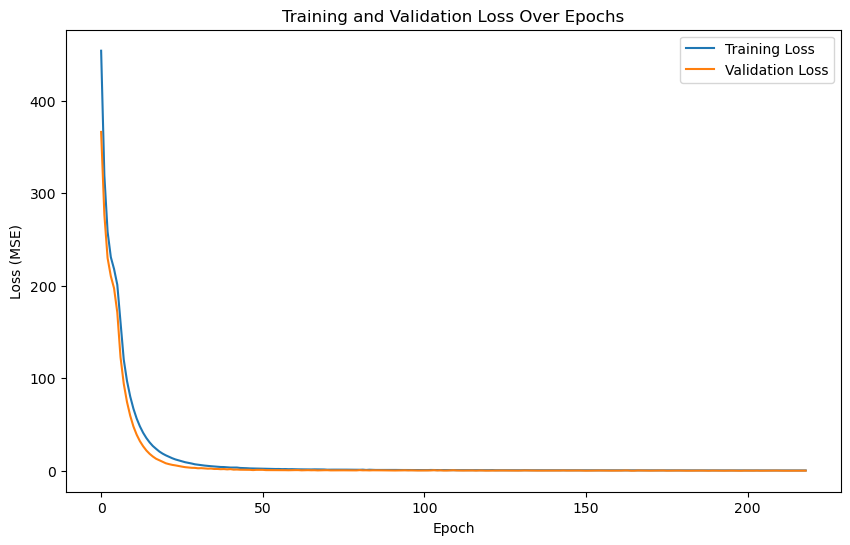

In [6]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'], label ='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')

plt.show()

By looking at the graph, we can see that the 2 curves almost coincide so there is no overfitting and we can say that our model 
generalizes well and that the model is learning the underlying patterns present in the data without specifically memorizing the training set's details.

We now have to test our neural network's pricing capabilities against test set.

To do so, we are going to calculate some performance metrics to assess how well the model performs on the test set and we are going to visualize the predicted values against the actual values in the test set to observe how well the model's predictions align with the true values.

In [7]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

loaded_model=load_model('my_model')

y_pred = loaded_model.predict(X_test)

mse=mean_squared_error(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

7/7 [==============================] - 0s 3ms/step
Mean Squared Error: 0.22305117613168696
Mean Absolute Error: 0.29975842148116855


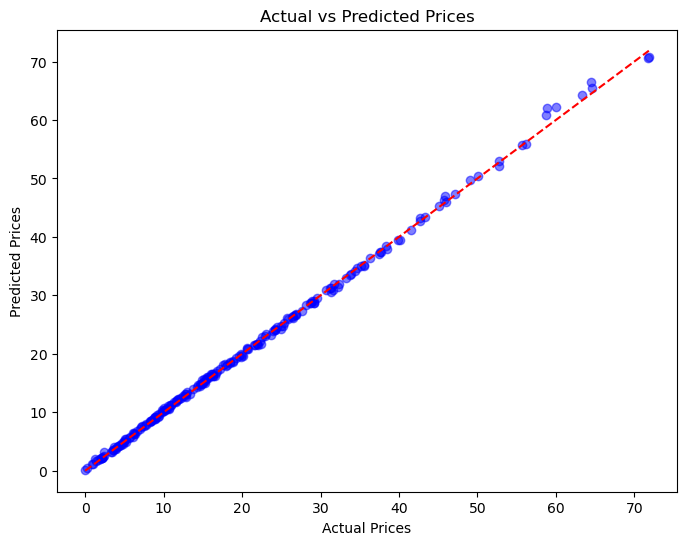

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

The red dashed line represents a perfect prediction line where actual and predicted values would be identical. By looking at the plot, we can see that points cluster closely around the diagonal red dashed line, indicating that the model's predictions are close to the true values.
Moreover, we have low values for both MSE and MAE. A low MSE indicates better agreement between predictions and actual values while a low MAE also signifies better model performance.
Both MSE and MAE are measures of prediction accuracy. As we have low values for both metrics, we can suggest that our model performs very well.

Now we're going to compute the time taken by the NN.

In [9]:
start_time = time.time()
pred_test = model.predict(X_train)
nn_time = time.time() - start_time
print(f"Total time taken by the Neural Network: {nn_time} seconds")
print(f"Total time taken by Monte Carlo: {execution_time} seconds")

55/55 [==============================] - 0s 2ms/step
Total time taken by the Neural Network: 0.25889062881469727 seconds
Total time taken by Monte Carlo: 192.2749526500702 seconds


We can see that our NN is really much faster than the traditional Monte Carlo method.
Moreover, using the results shown previously, our NN is also quite accurate at pricing the Barrier Option prices. 

Even if our NN is not as accurate as the Monte Carlo method it is faster and quite accurate. 
However, in general, Neural network's accuracy depend on the hyperparameters chosen (learning rate, number of layers, etc...), the quantity of labeled data used for training and Neural Networks are susceptible to overfitting, especially when dealing with noisy or small datasets.

But if you have chosen the best hyperparameters for your Neural Networks and your data is of high quality, your Neural Network can be as accurate as the Monte Carlo method. 

For example, our Neural Network is quite fast and quite accurate but we could make it better as suggests our loss value, MSE and MAE.